In [1]:
from pathlib import Path
import tensorflow as tf
import pickle
import datetime as dt
from datetime import datetime

from tqdm import tqdm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt   
import numpy as np

import importlib
import stockanalibs
importlib.reload(stockanalibs)

2025-06-27 22:17:48.127913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751055468.176553    6721 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751055468.192386    6721 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751055468.273352    6721 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751055468.273403    6721 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751055468.273406    6721 computation_placer.cc:177] computation placer alr

<module 'stockanalibs' from '/mnt/g/My Drive/Ingegneria/Data Science GD/My-Practice/my models/Trading/0.Stock Analysis/stockanalibs.py'>

In [2]:
ticker        = stockanalibs.ticker
date_load     = '2025-06-27'
save_dir      = Path("dfs training")

look_back     = stockanalibs.look_back
label_col     = stockanalibs.label_col
feature_cols  = stockanalibs.feature_cols

In [3]:
# load model (architecture + weights already inside) ────────────
file_path = save_dir / f"{ticker}_{date_load}_model.keras"
model_test = tf.keras.models.load_model(file_path)

# Re-load weights-only checkpoint in case updated
ckpt_path  = save_dir / f"{ticker}_{date_load}.weights.h5"
model_test.load_weights(ckpt_path)      

# load tf.data test set exactly as it was saved ─────────────────
ds_test = tf.data.Dataset.load(str(save_dir / f"{ticker}_ds_test"), compression="GZIP")


I0000 00:00:1751055474.665207    6721 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/alfrizz/miniconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 25 variables whereas the saved optimizer has 1 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/alfrizz/miniconda3/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 25 variables whereas the saved optimizer has 29 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [4]:
model_test.summary()

Model: "dual_mem_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inp (InputLayer)                │ (1, None, 300)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ short_lstm (LSTM)               │ (1, None, 48)          │        67,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_short (Dropout)         │ (1, None, 48)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ln_short (LayerNormalization)   │ (1, None, 48)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ long_lstm (LSTM)                │ (1, None, 128)         │        90,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_long (Dropout)          │ (1, None, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ln_long (LayerNormalization)    │ (1, None, 128)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pred (TimeDistributed)          │ (1, None, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 474,340 (1.81 MB)

 Trainable params: 158,113 (617.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 316,227 (1.21 MB)

In [5]:
model_test.get_config()

{'name': 'dual_mem_lstm',
 'trainable': True,
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (1, None, 300),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'inp'},
   'registered_name': None,
   'name': 'inp',
   'inbound_nodes': []},
  {'module': 'keras.layers',
   'class_name': 'LSTM',
   'config': {'name': 'short_lstm',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'return_sequences': True,
    'return_state': False,
    'go_backwards': False,
    'stateful': True,
    'unroll': False,
    'zero_output_for_mask': False,
    'units': 48,
    'activation': 'tanh',
    'recurrent_activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'Orthogonal',
     'config': {'seed': None, 'gain': 1.0},
     'registered_name': None},
  

In [6]:
short_val = [l for l in model_test.layers if l.name == "short_lstm"]
long_val  = [l for l in model_test.layers if l.name == "long_lstm"]

lstm_layers = {"short": short_val, "long": long_val}
lstm_layers

{'short': [<LSTM name=short_lstm, built=True>],
 'long': [<LSTM name=long_lstm, built=True>]}

In [7]:
def reset_states_for_day(lstm_layers, reset_long=False):
    """
    Reset LSTM states based on the training/validation logic.
    
    Short-term LSTM layers (under the "short" key) are always reset, while long-term
    LSTM layers (under the "long" key) are reset only when a week transition is detected.

    Parameters:
      lstm_layers (dict): Dictionary with two keys:
          "short": list of short-term LSTM layers.
          "long":  list of long-term LSTM layers.
      reset_long (bool): If True, resets long-term LSTM layers.
    
    Returns:
      None.
    """
    # Reset all short-term LSTM layers.
    for layer in lstm_layers.get("short", []):
        layer.reset_states()
    # Reset long-term LSTM layers if necessary.
    if reset_long:
        for layer in lstm_layers.get("long", []):
            layer.reset_states()


In [8]:

def test_rmse(model, ds_test, lstm_layers):
    """
    Evaluate the RMSE over the test dataset on a day-by-day basis using the same state
    reset logic as in training/validation.
    
    The test dataset is assumed to yield a 6-tuple per day:
      (X_day, y_day, raw_close, raw_bid, raw_ask, day_id)
    where:
      - X_day has shape (1, T, n_feats) (the entire day’s inputs),
      - y_day has shape (1, T) (the pre-aligned targets),
      - raw_close, raw_bid, raw_ask are the raw price signals (unused in this function), and
      - day_id is a scalar (or tensor) representing the day (0=Mon, …, 6=Sun).
    
    For each day:
      1. The LSTM states are reset (short-term and, if a new week is detected,
         long-term) using the weekday information.
      2. A forward pass is run on X_day to get predictions.
      3. The predictions (of shape (1, T, 1)) are squeezed to a 1-D vector of shape (T,).
      4. The true targets are squeezed similarly.
      5. The RMSE metric is updated with these values.
    
    Returns:
      float: the final RMSE computed over all test days.
    """
    # Initialize the RMSE metric.
    rmse_metric = tf.keras.metrics.RootMeanSquaredError(name="rmse")
    
    # Use caching to speed up processing.
    ds_test = ds_test.cache()
    
    # Count the number of test days.
    N_test = sum(1 for _ in ds_test)
    
    prev_day = None

    # Iterate over each test day.
    for X_day, y_day, _, _, _, day_id in tqdm(ds_test, total=N_test, unit="day", desc="Testing RMSE"):
        # Determine the current day (for state reset) using your helper.
        current_wd = int(day_id.numpy())
        if prev_day is None:
            reset_long = True
        else:
            reset_long = current_wd < prev_day  # e.g., a transition from Friday (4) to Monday (0)
        reset_states_for_day(lstm_layers, reset_long=reset_long)
        prev_day = current_wd

        # Run model inference. Expect shape: (1, T, 1)
        y_pred = model(X_day, training=False)
        # Squeeze the output along batch (axis 0) and last dimensions (axis 2) to get shape (T,)
        y_pred = tf.squeeze(y_pred, axis=[0, 2])
        # Squeeze the target y_day (shape from (1, T) to (T,))
        y_true = tf.squeeze(y_day, axis=0)

        # Update the RMSE metric.
        rmse_metric.update_state(y_true, y_pred)

    # Final RMSE result.
    rmse_value = rmse_metric.result().numpy()
    print(f"\nFINAL OOS TEST RMSE = {rmse_value:.5f}")
    return rmse_value


In [9]:
# First, evaluate the RMSE over all test sessions:
rmse_value = test_rmse(model_test, ds_test, lstm_layers)
rmse_value

Testing RMSE:   0%|          | 0/422 [00:00<?, ?day/s]

I0000 00:00:1751055482.284845    6788 cuda_dnn.cc:529] Loaded cuDNN version 91002



FINAL OOS TEST RMSE = 0.18929


0.18928629

In [10]:
def plot_test_sessions(model, ds_test, lstm_layers, look_back, feature_cols, N_plots=30):
    """
    Generates visual plots for a subset of test days showing:
      - Standardized true target and model predictions on the primary y-axis.
      - Raw (unstandardized) close prices on the secondary y-axis.
    
    Expects each sample from ds_test to be a 6-tuple:
       (X_day, y_day, raw_close, raw_bid, raw_ask, day_id)
    
    Parameters:
      model (tf.keras.Model): Trained model.
      ds_test (tf.data.Dataset): Test dataset yielding the 6-tuple per day.
      lstm_layers (dict): Dictionary with keys "short" and "long" (stateful LSTM layers).
      look_back (int): Number of time steps per sliding window.
      feature_cols (List[str]): List of feature names (must include "close").
      N_plots (int): Maximum number of test sessions (days) to plot.
    """
    # Determine index of the "close" feature.
    close_idx = feature_cols.index("close")
    
    plotted = 0
    prev_day = None  # store previous weekday (as a plain integer)
    
    for X_day, y_day, raw_close, raw_bid, raw_ask, day_id in tqdm(ds_test, unit="day", desc="Plotting Test Sessions"):
        current_wd = int(day_id.numpy())
        if prev_day is None:
            reset_long = True
        else:
            reset_long = current_wd < prev_day  # new week if crossover is detected
        reset_states_for_day(lstm_layers, reset_long=reset_long)
        prev_day = current_wd
        
        # Get model predictions and ground truth.
        y_pred = model(X_day, training=False).numpy().squeeze()   # shape: (T,)
        y_true = tf.squeeze(y_day).numpy()                         # shape: (T,)
        real_close = tf.squeeze(raw_close).numpy()                 # shape: (T,)
        
        # Plot using a two-axis figure.
        fig, ax1 = plt.subplots(figsize=(10, 3))
        ax1.plot(y_true, label="True y", color="black", linewidth=2)
        ax1.plot(y_pred, label="Predicted ŷ", color="firebrick",
                 linestyle="dashed", linewidth=2, alpha=0.8)
        ax1.set_xlabel("Time steps (bars)")
        ax1.set_ylabel("Target & Predicted Signal (standardized)")
        ax1.legend(loc="upper left")
        ax1.grid(True)
        
        ax2 = ax1.twinx()
        ax2.plot(real_close, label="Real Close", color="blue",
                 linestyle="--", linewidth=2)
        ax2.set_ylabel("Real Close")
        ax2.legend(loc="upper right")
        
        plt.title(f"Test Session #{plotted+1} • Length = {len(y_true)} bars", fontsize=12)
        plt.show()
        
        plotted += 1
        if plotted >= N_plots:
            break


Plotting Test Sessions:   0%|          | 0/422 [00:00<?, ?day/s]

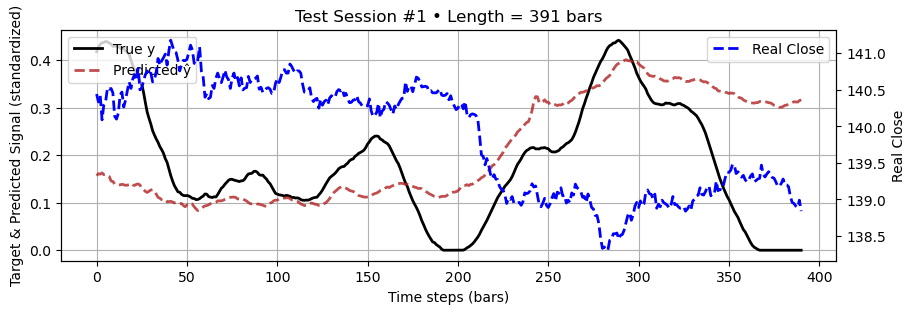

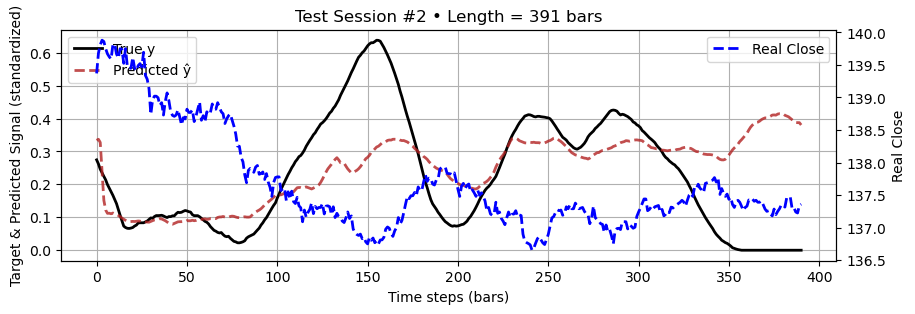

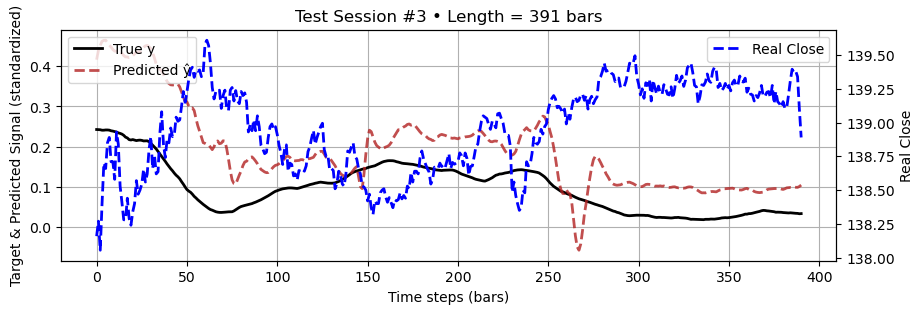

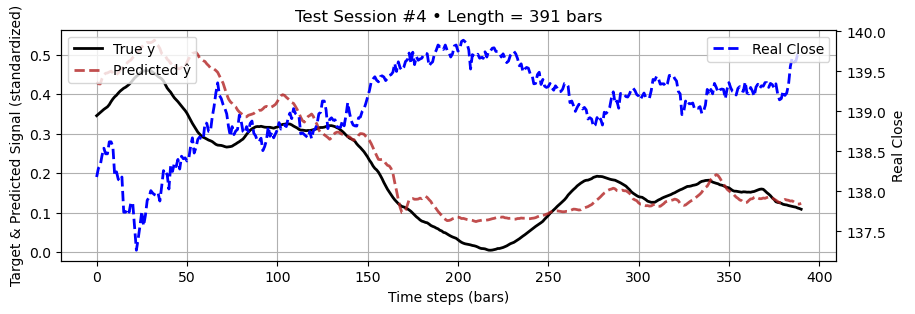

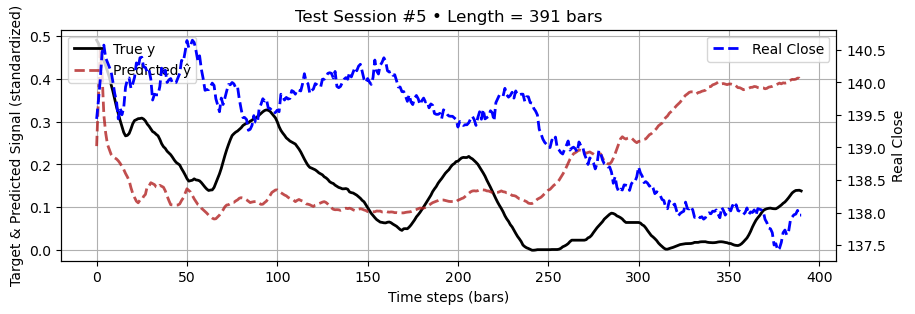

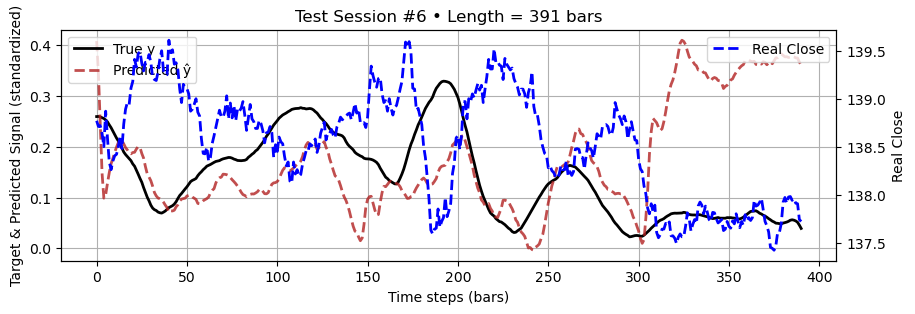

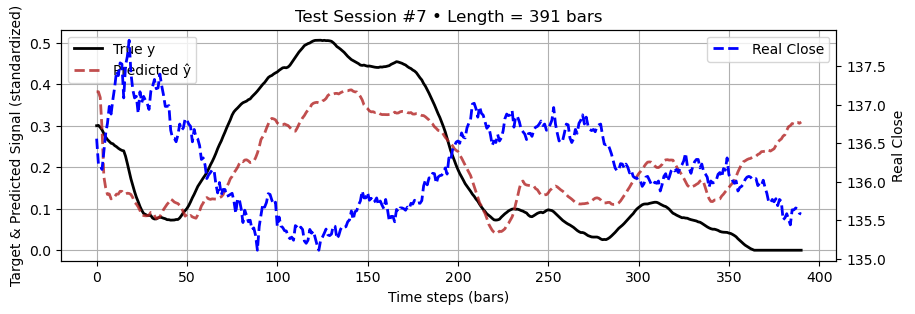

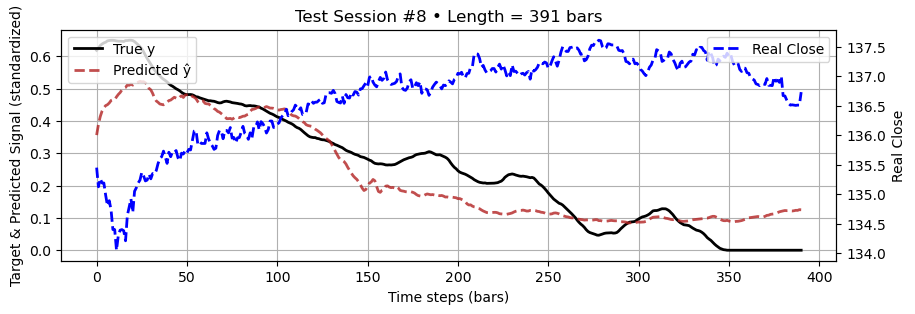

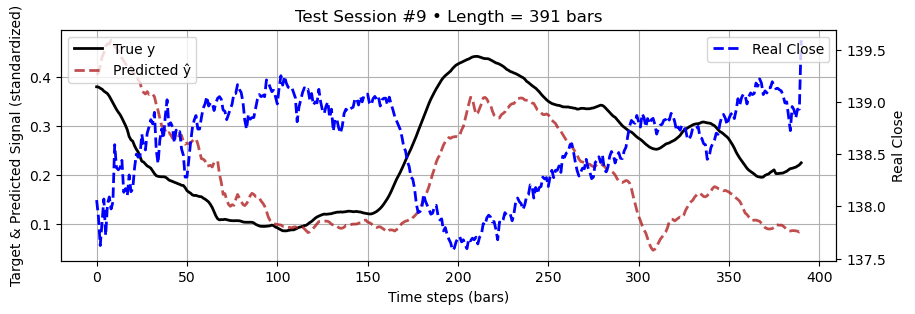

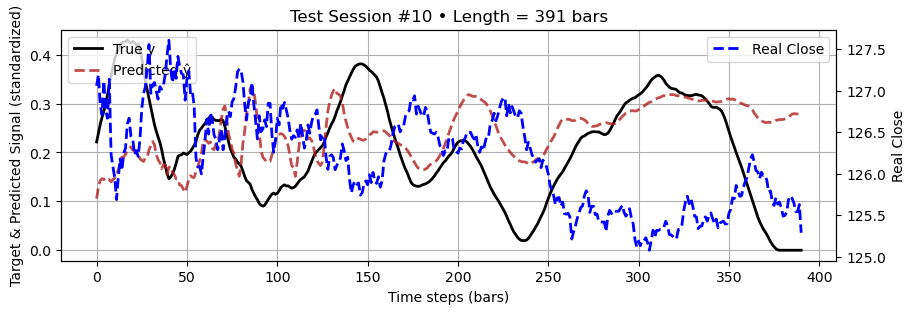

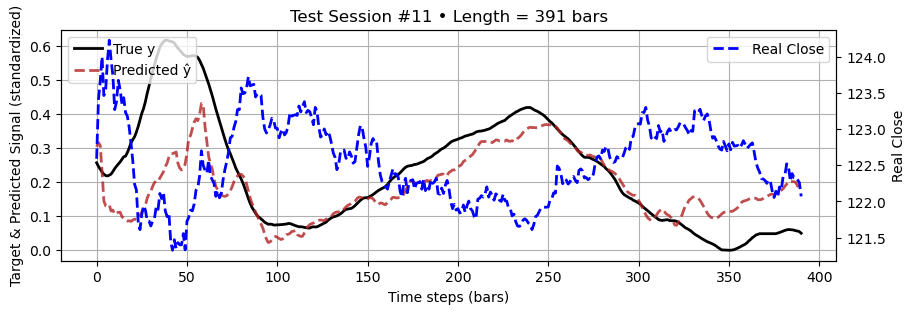

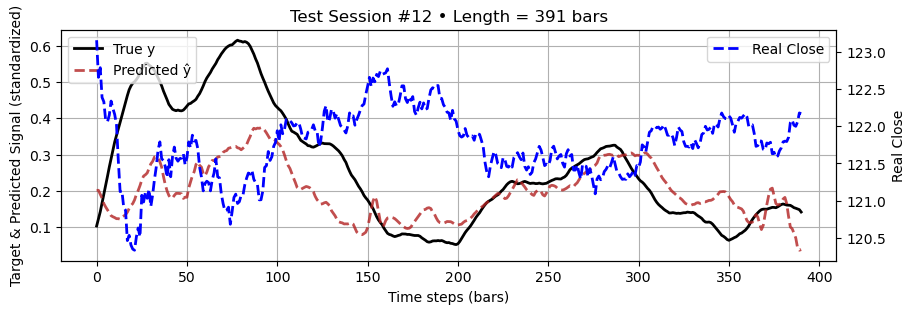

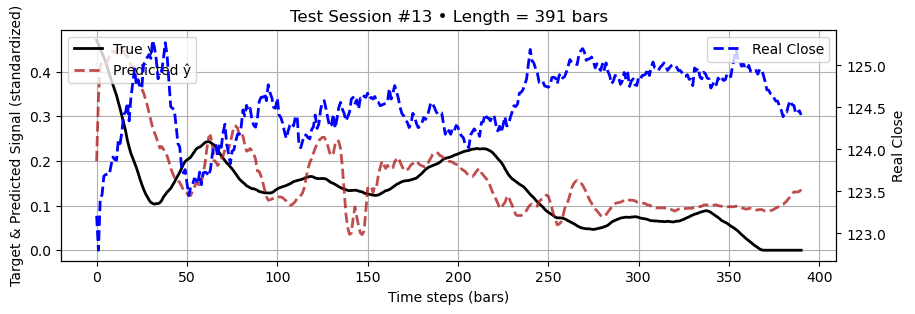

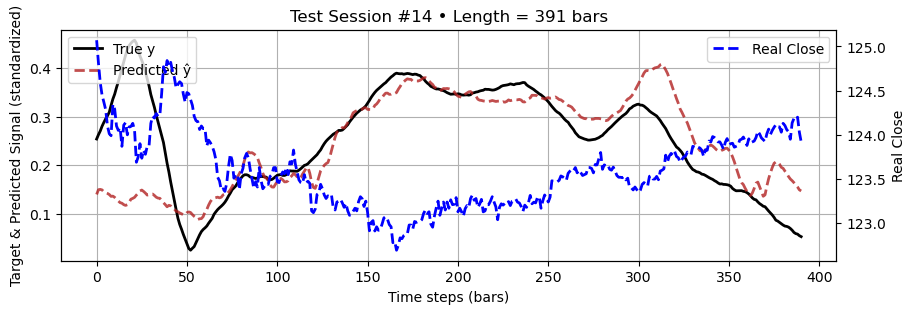

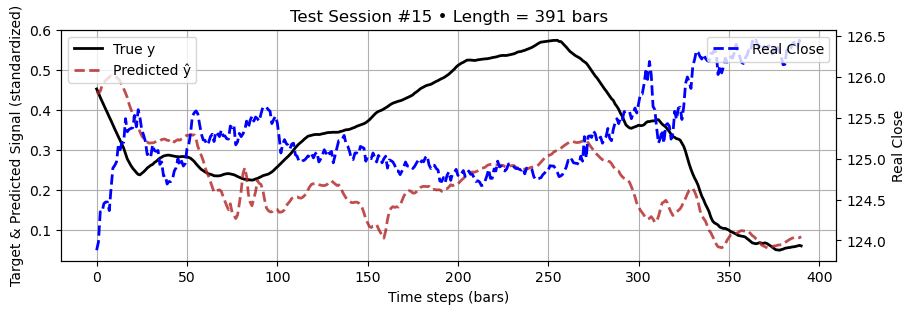

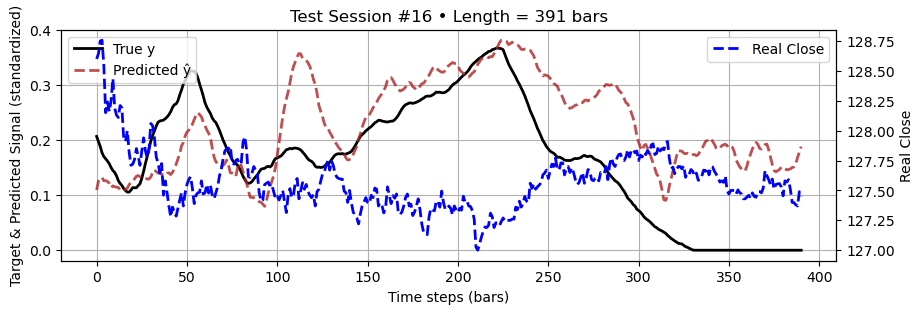

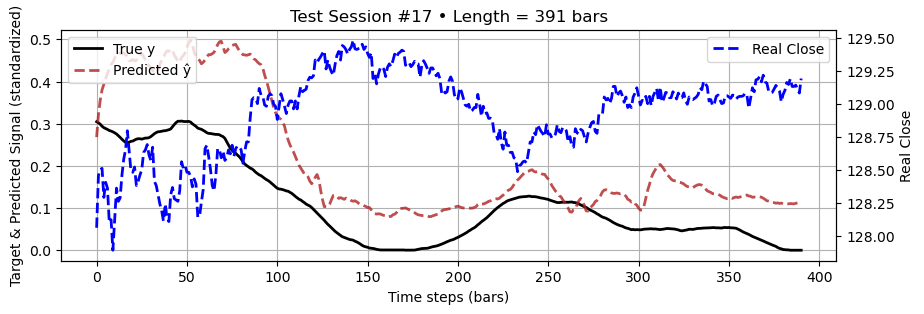

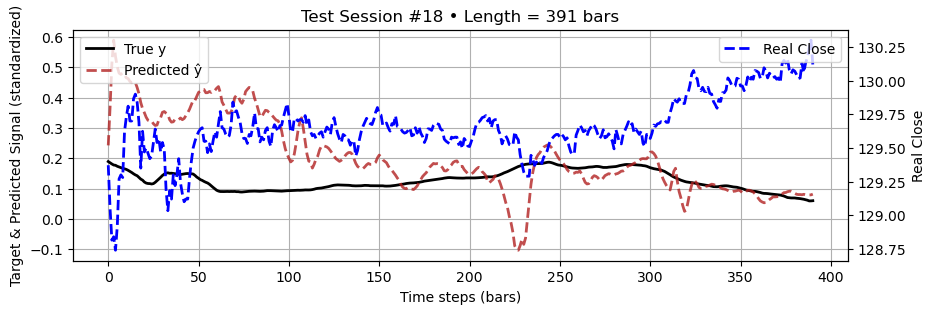

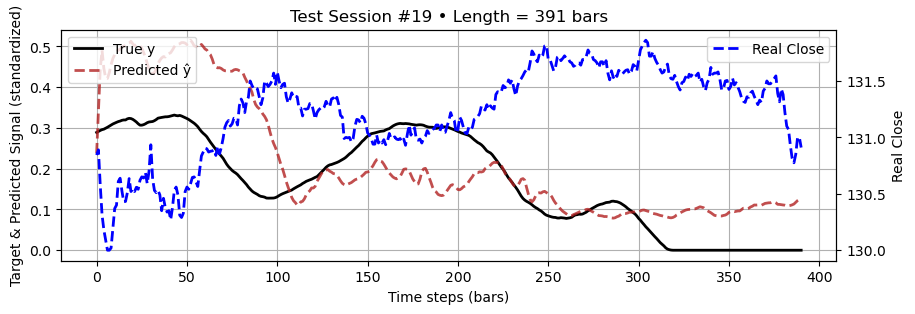

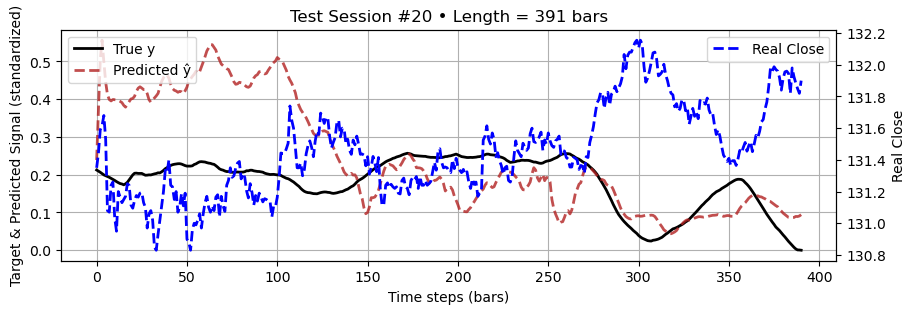

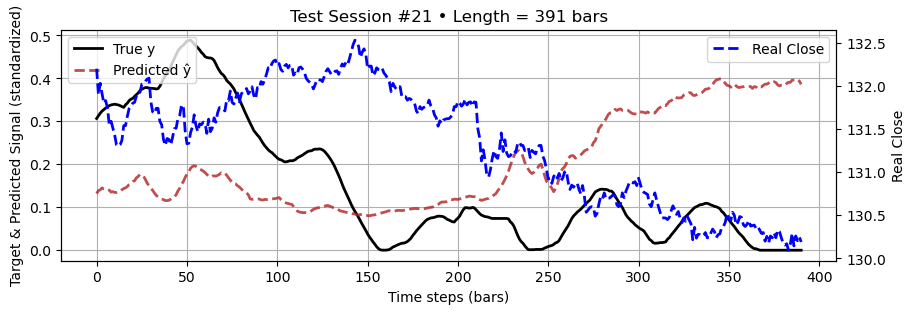

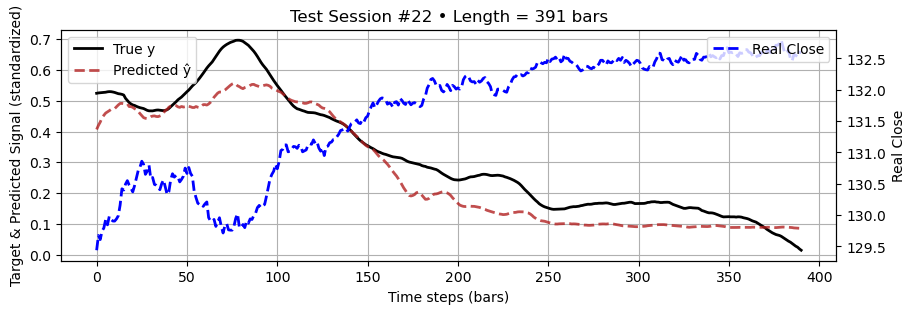

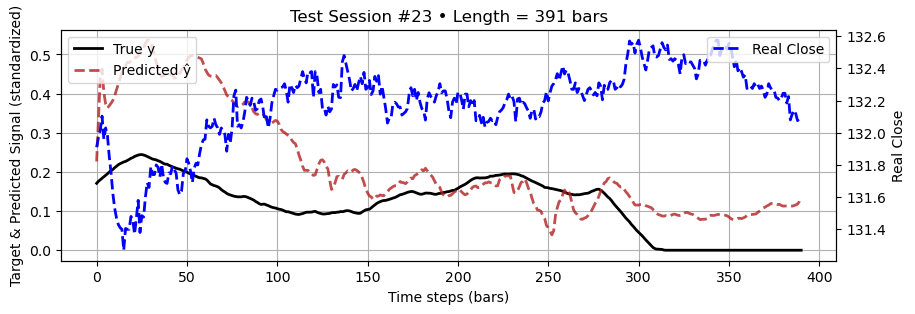

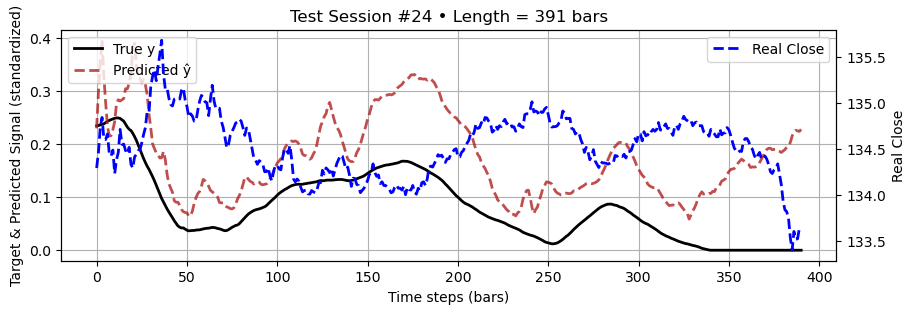

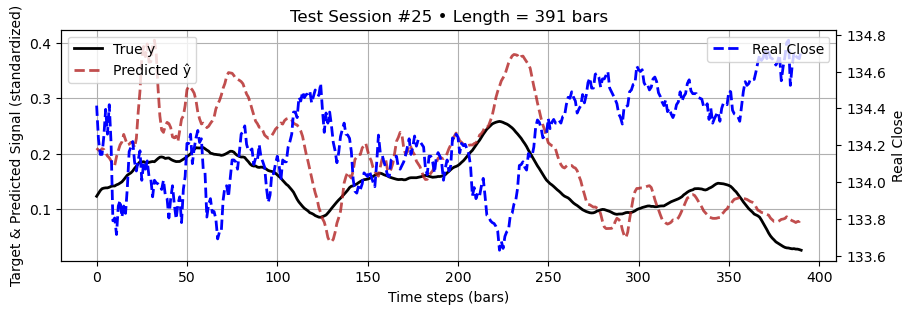

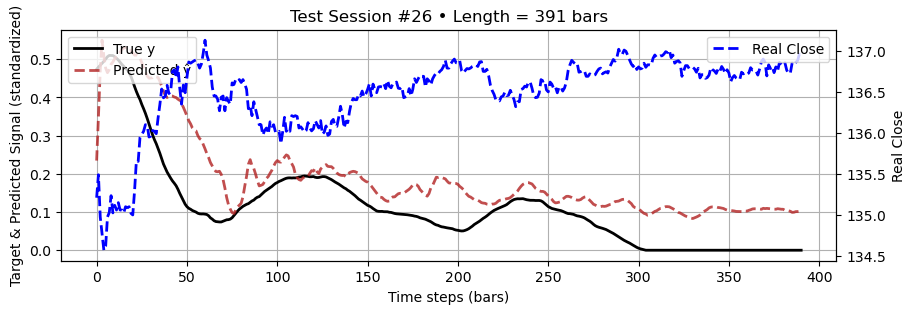

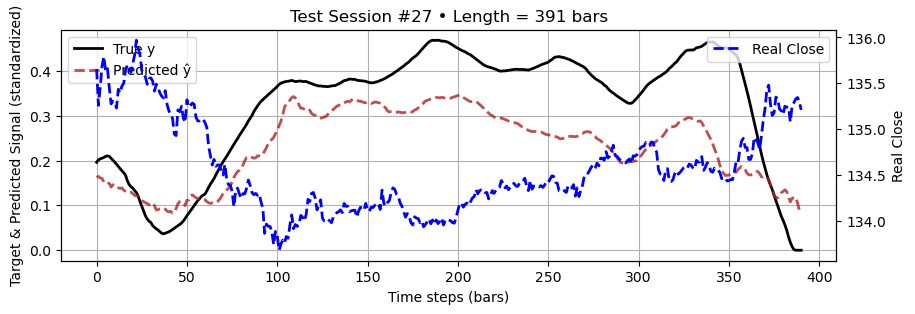

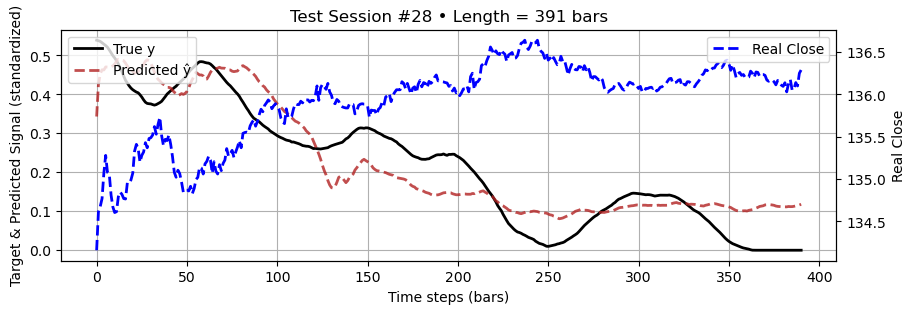

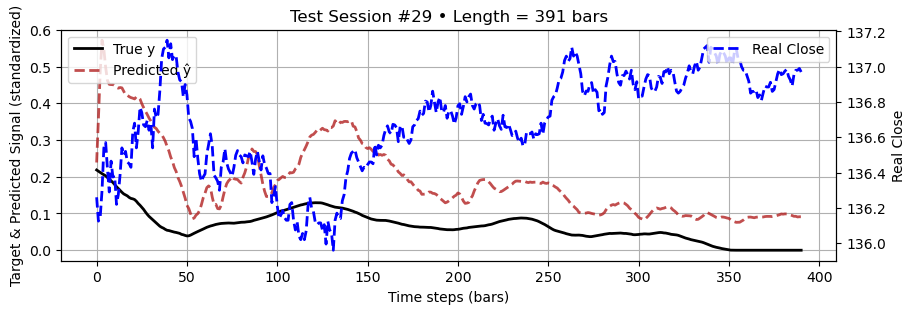

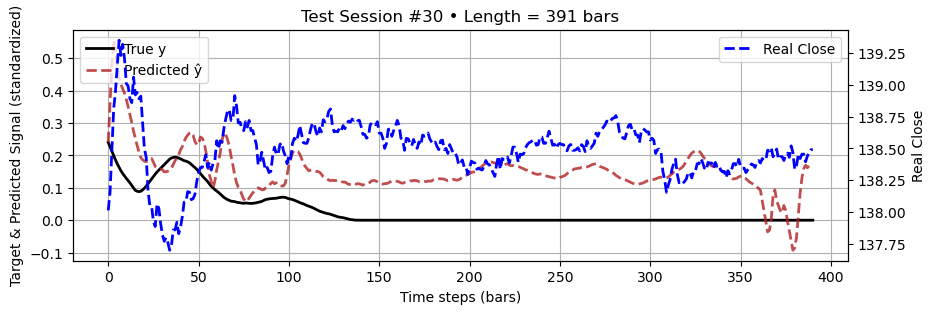

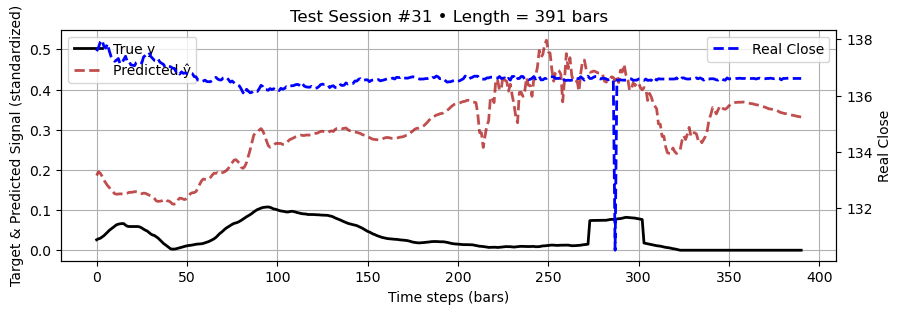

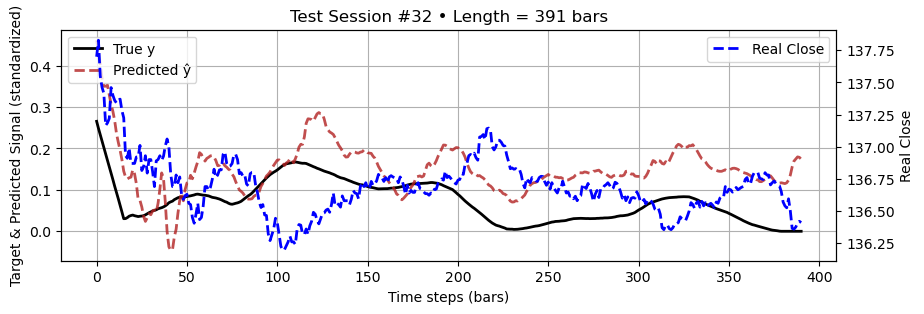

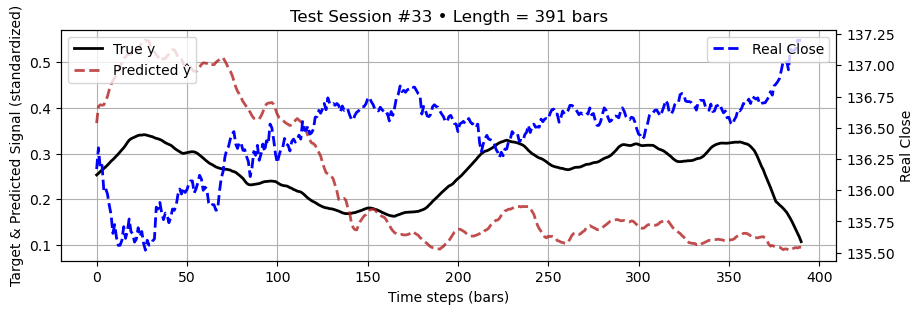

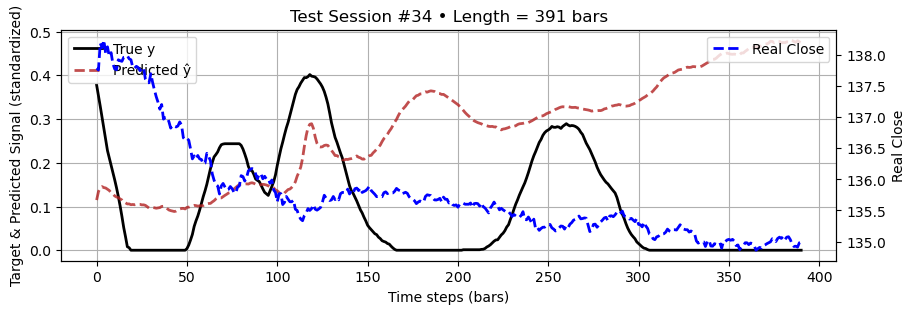

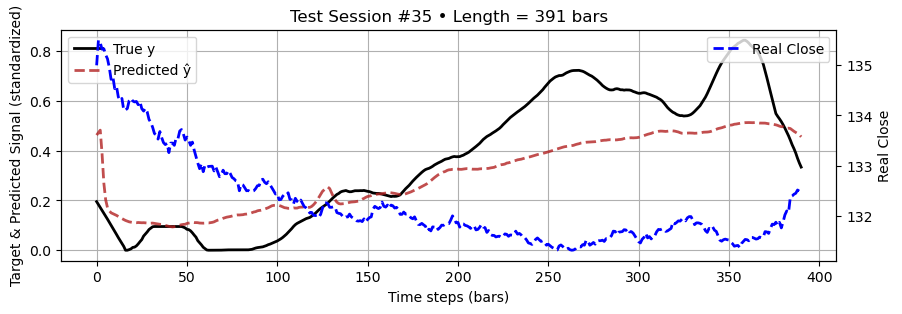

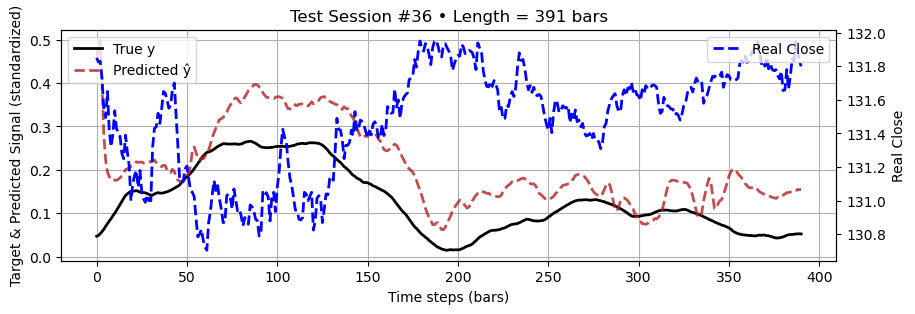

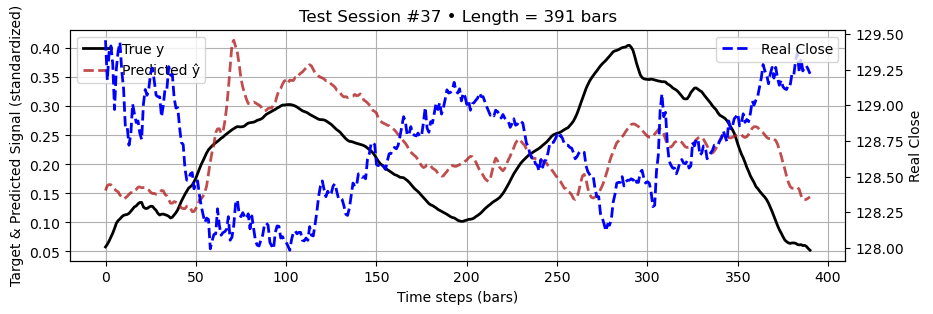

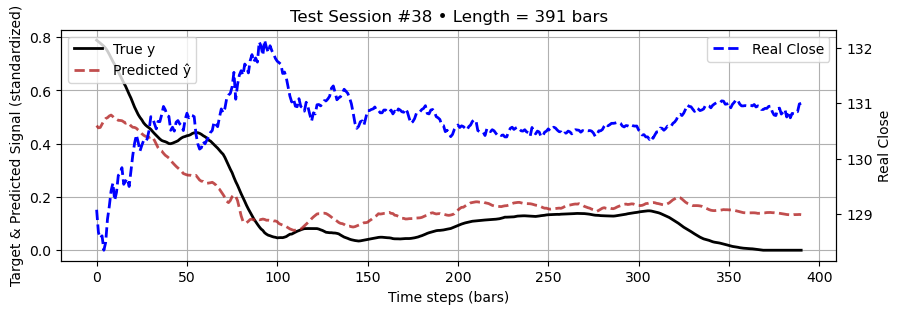

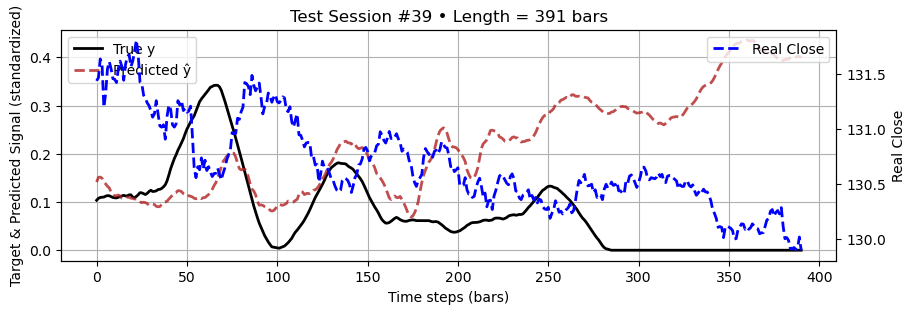

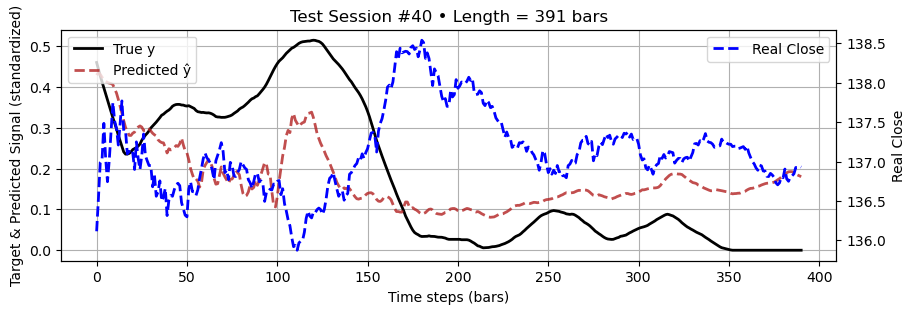

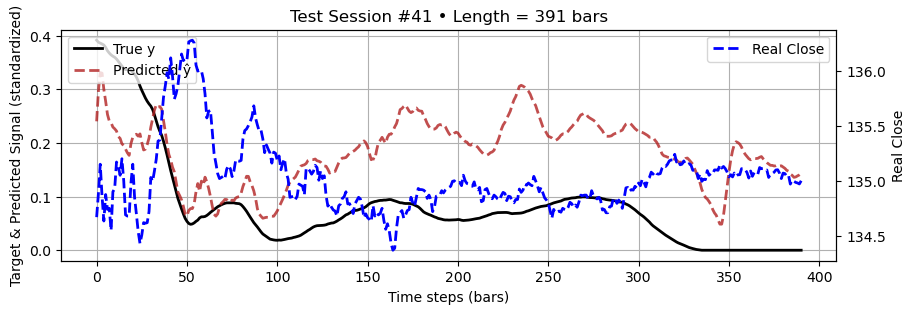

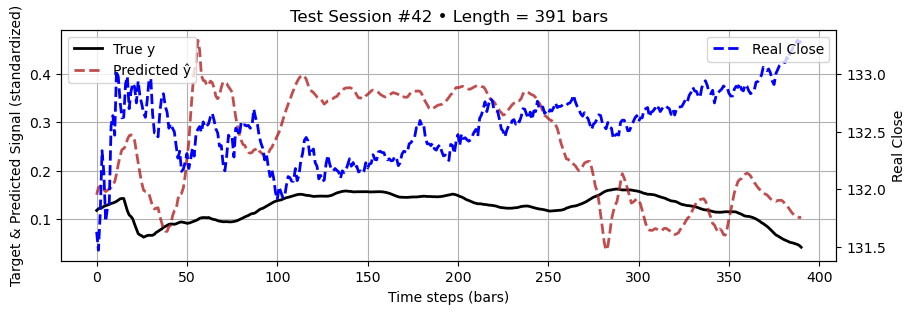

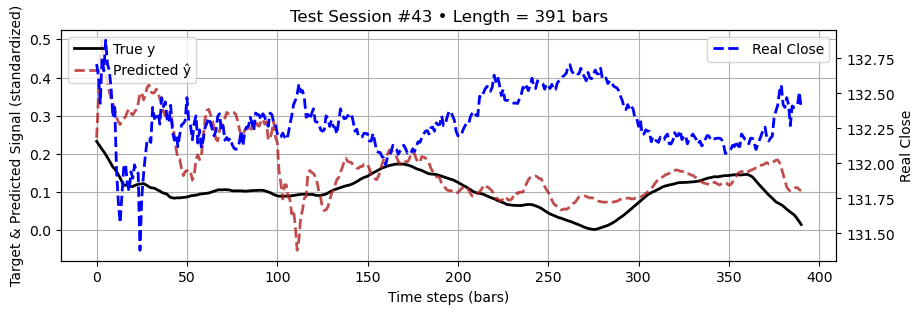

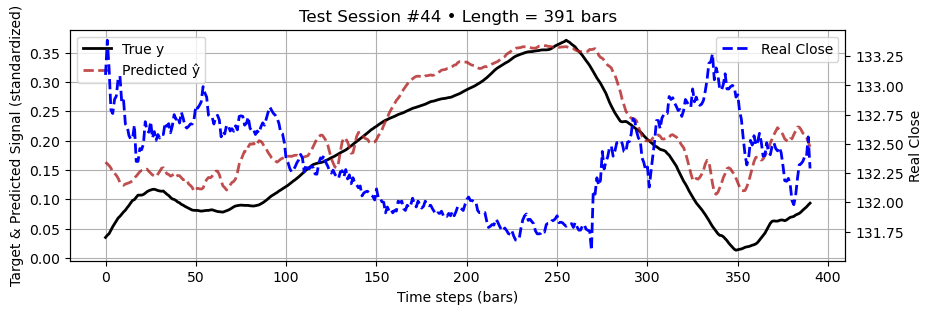

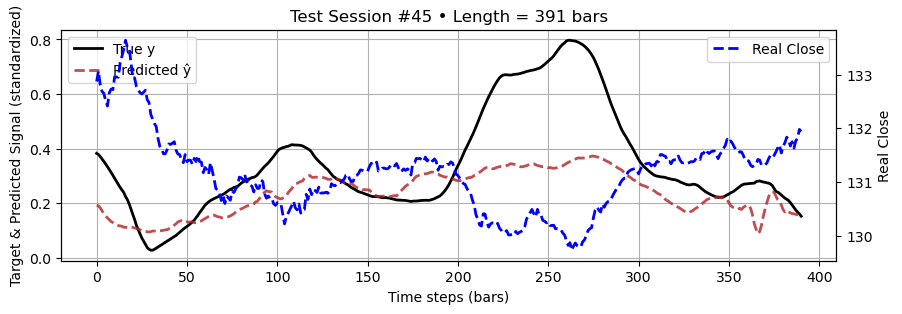

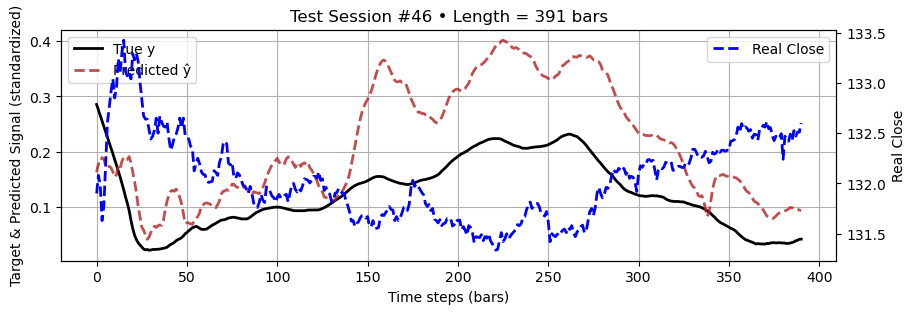

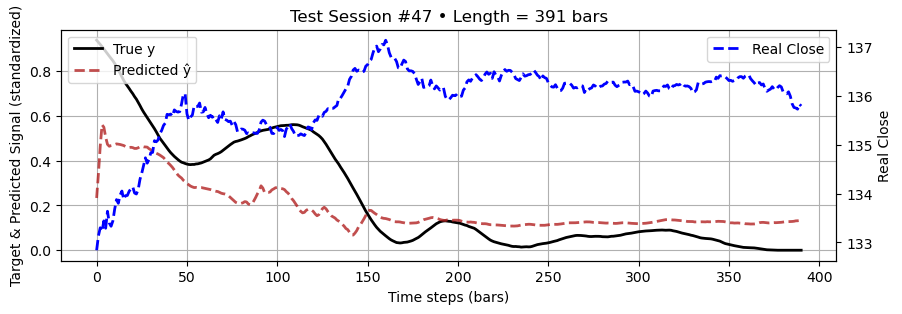

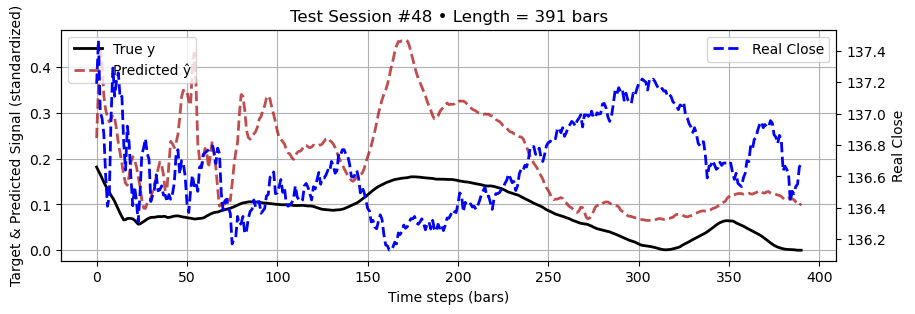

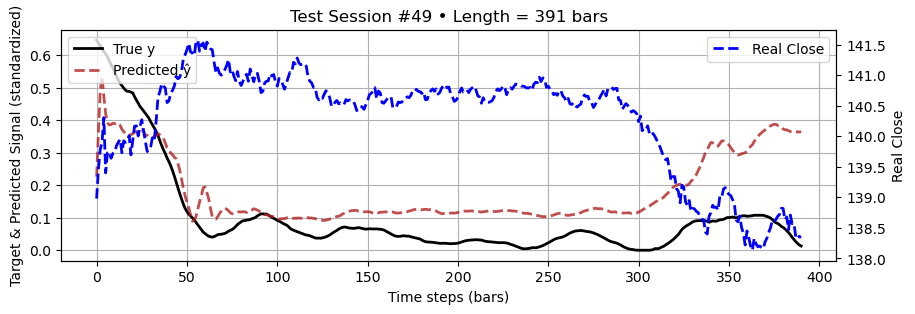

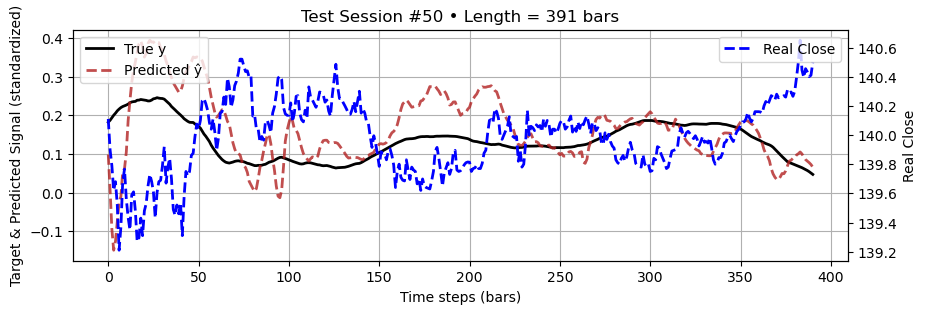

In [11]:
# Then, generate the visual sanity-check plots (with two y-axes):
plot_test_sessions(model_test, ds_test, lstm_layers, look_back, feature_cols, N_plots=50)